In [1]:
# camera calibration
from os import listdir
from scipy import misc
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


CAM_CAL_PATH = './camera_cal/'

cam_cal_imgs = []
for img_file in listdir(CAM_CAL_PATH):
    try:
        img = misc.imread(CAM_CAL_PATH + img_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        cam_cal_imgs.append(img)
    except IOError: pass

17 found.


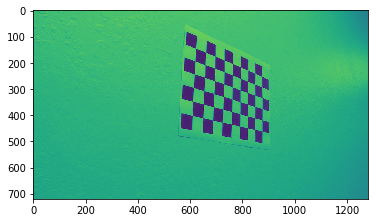

In [2]:
objp = np.zeros((6 * 9, 3), np.float32)
objp[:,:2] = np.mgrid[0:6, 0:9].T.reshape(-1,2)

object_points = []
img_points = []
for img in cam_cal_imgs:
    plt.imshow(img)
    ret, corners = cv2.findChessboardCorners(img, (9, 6), None)
    if (ret):
        object_points.append(objp)
        img_points.append(corners)

print (len(img_points), 'found.')

In [3]:
img_size = (cam_cal_imgs[1].shape[1], cam_cal_imgs[1].shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points, img_points, img_size,None,None)

In [4]:
print (mtx, dist)

[[ 143.08147127    0.          639.4956478 ]
 [   0.          817.84727475  359.49932344]
 [   0.            0.            1.        ]] [[ -1.08929527e-02   3.00019798e-05  -4.85444918e-05   1.57584130e-03
   -2.35174525e-08]]


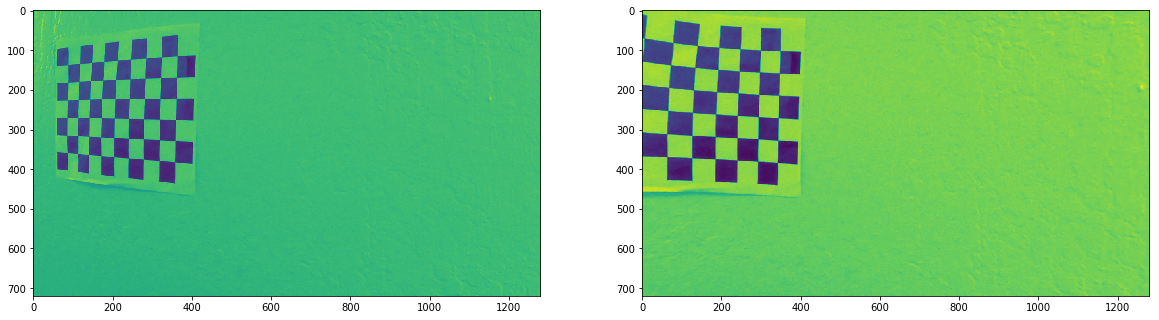

In [5]:
undist_test = cv2.undistort(cam_cal_imgs[10], mtx, dist, None, mtx)
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(cam_cal_imgs[10])
plt.subplot(1,2,2)
plt.imshow(undist_test)


In [6]:
# loading the test images
TEST_PATH = './test_images/'

test_img = []
for img_file in listdir(TEST_PATH):
    try:
        img = misc.imread(TEST_PATH + img_file)
        test_img.append(img)
    except IOError: pass



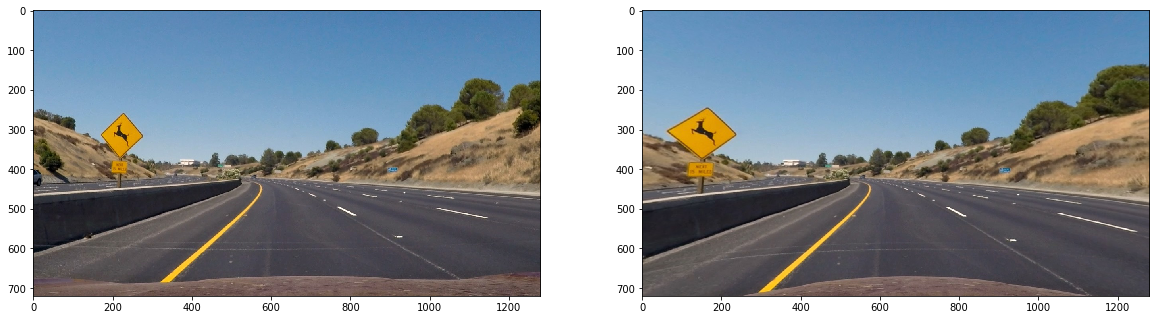

In [7]:
n = 3
undist_test = cv2.undistort(test_img[n], mtx, dist, None, mtx)
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(test_img[n])
plt.subplot(1,2,2)
plt.imshow(undist_test)


In [8]:
# the pipeline magic
###############

def undistort(image):
    return cv2.undistort(image, mtx, dist, None, mtx)
    

def gradient_transform_x(image, ksize=5, thresh=(0,255)):
    img = np.copy(image)
    sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=ksize)    
    sobelx = np.absolute(sobelx / np.max(sobelx) * 255)
    grads = np.zeros(img.shape)
    grads[(sobelx > thresh[0]) & (sobelx < thresh[1])] = 1
    return grads

def gradient_transform_y(image, ksize=5, thresh=(0,255)):
    img = np.copy(image)
    sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=ksize)    
    sobely = np.absolute(sobely / np.max(sobely) * 255)
    grads = np.zeros(img.shape)
    grads[(sobely > thresh[0]) & (sobely < thresh[1])] = 1
    return grads

def gradient_transform_direction(image, ksize=5, thresh=(0 , 3.14)):
    img = np.copy(image)
    sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=ksize)
    sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=ksize)
    grad_direction = np.arctan2(sobely, sobelx)
    grad_direction = np.absolute(grad_direction)
    
    grads = np.zeros(grad_direction.shape)
    grads[(grad_direction > thresh[0]) & (grad_direction < thresh[1])] = 1
    return grads

def warp(img, M):
    size = (img.shape[1], img.shape[0])
    return cv2.warpPerspective(img, M, size, flags=cv2.INTER_LINEAR)


[MoviePy] >>>> Building video gradient_test_vid.mp4
[MoviePy] Writing video gradient_test_vid.mp4


100%|█████████▉| 1260/1261 [05:36<00:00,  2.79it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: gradient_test_vid.mp4 



'\nl = len(test_img)\nfor i, image in enumerate(test_img[-4:]):\n    img = undistort(image)\n    plt.subplot(l, 2, i * 2 + 1)\n    plt.imshow(img)\n    plt.subplot(l, 2, i * 2 + 2)\n    plt.imshow(gradient_transform_wrapper(img))\n'

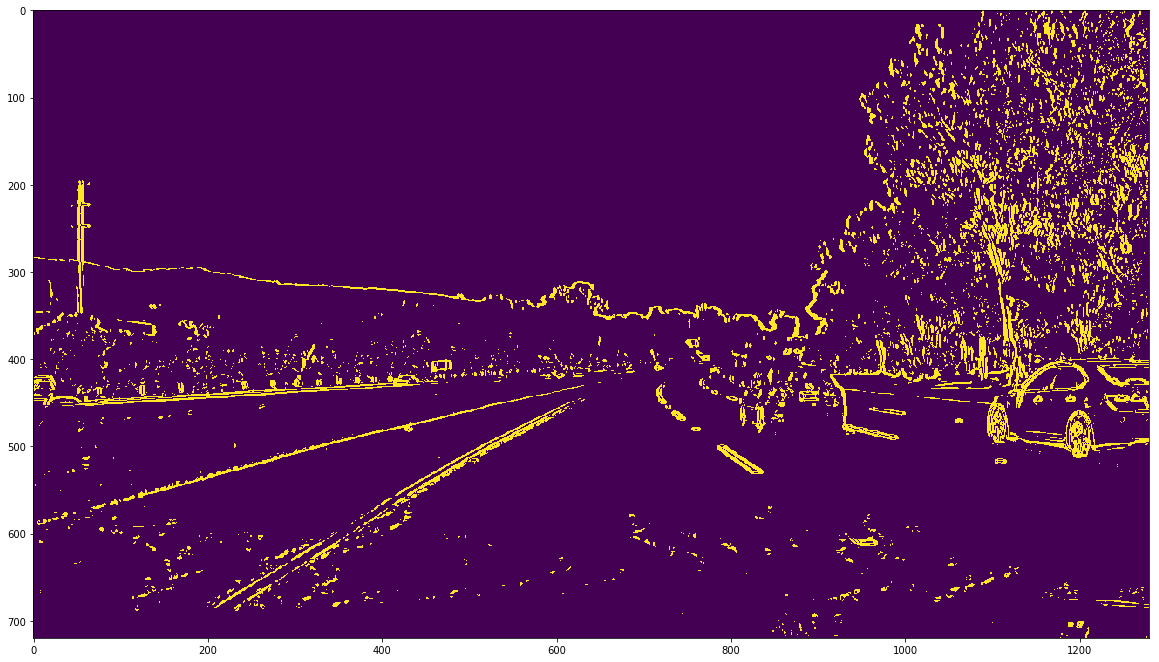

In [120]:
def gradient_transform_wrapper(image):
    img = np.copy(image)
    
    l_chan = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)[:,:,2]
    gx = gradient_transform_x(l_chan, ksize = 7, thresh=(30, 150))
    gy = gradient_transform_y(l_chan, ksize = 7, thresh=(30, 150))
    gd = gradient_transform_direction(l_chan, ksize=7, thresh=(1.5,2.3)) 
    combo_hls = np.zeros(l_chan.shape)
    combo_hls[((gx == 1) | (gx == 1)) & (gd == 1)] = 1
    
    bw = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gx = gradient_transform_x(bw, ksize = 7, thresh=(30, 150))
    gy = gradient_transform_y(bw, ksize = 7, thresh=(70, 150))
    #gd = gradient_transform_direction(img, ksize=7, thresh=(1.7,2.4)  
    combo_bw = np.zeros(bw.shape)
    combo_bw[(gy == 1) | (gx == 1)] = 1                                      
    
    combo = np.zeros(bw.shape)
    combo[(combo_bw == 1) | (combo_hls == 1)] = 1
    
    
    return combo

def grad3d(image):
    out = gradient_transform_wrapper(image) * 254
    img = np.zeros((image.shape[0],image.shape[1],3 ))
    img[:,:,0] = out
    img[:,:,1] = out
    img[:,:,2] = out
    return np.concatenate((image,img), axis=1)

from moviepy.editor import VideoFileClip

INPUT_VIDEO = './project_video.mp4'

def write_video(input_f, output_f, f):
    clip = VideoFileClip(input_f) #.subclip(35,44)
    transformed = clip.fl_image(f)
    transformed.write_videofile(output_f, audio=False)
 

INPUT_VIDEO = './project_video.mp4'
write_video(INPUT_VIDEO, 'gradient_test_vid.mp4', grad3d)

plt.figure(figsize=(20,40))

img = VideoFileClip(INPUT_VIDEO).get_frame(42)


plt.imshow(gradient_transform_wrapper(img))
"""
l = len(test_img)
for i, image in enumerate(test_img[-4:]):
    img = undistort(image)
    plt.subplot(l, 2, i * 2 + 1)
    plt.imshow(img)
    plt.subplot(l, 2, i * 2 + 2)
    plt.imshow(gradient_transform_wrapper(img))
"""
    

In [11]:
misc.imsave('calib.png', undistort(test_img[0]))


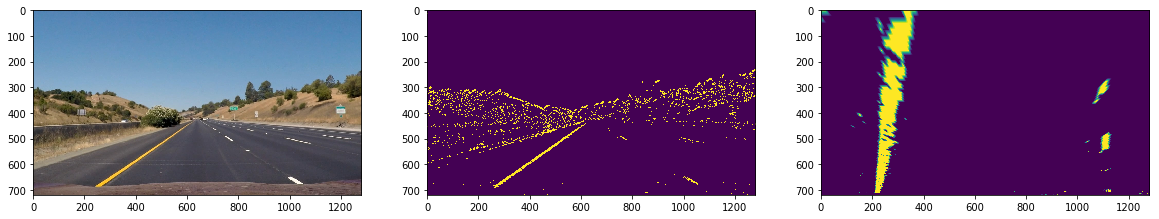

In [12]:
n = 0
src = np.float32([[205, 720]     #720
                 ,[535, 490]
                 ,[750, 490]     #490
                 ,[1101, 720]])

dst = np.float32([[205, 720]
                 ,[205, 490]
                 ,[1101, 490]
                 ,[1101, 720]])

M = cv2.getPerspectiveTransform(src, dst)
M_INV = cv2.getPerspectiveTransform(dst, src)

warped = warp(gradient_transform_wrapper(test_img[n]), M)
plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.imshow(test_img[n])
plt.subplot(1,3,2)
plt.imshow(gradient_transform_wrapper(test_img[n]))
plt.subplot(1,3,3)
plt.imshow(warped)

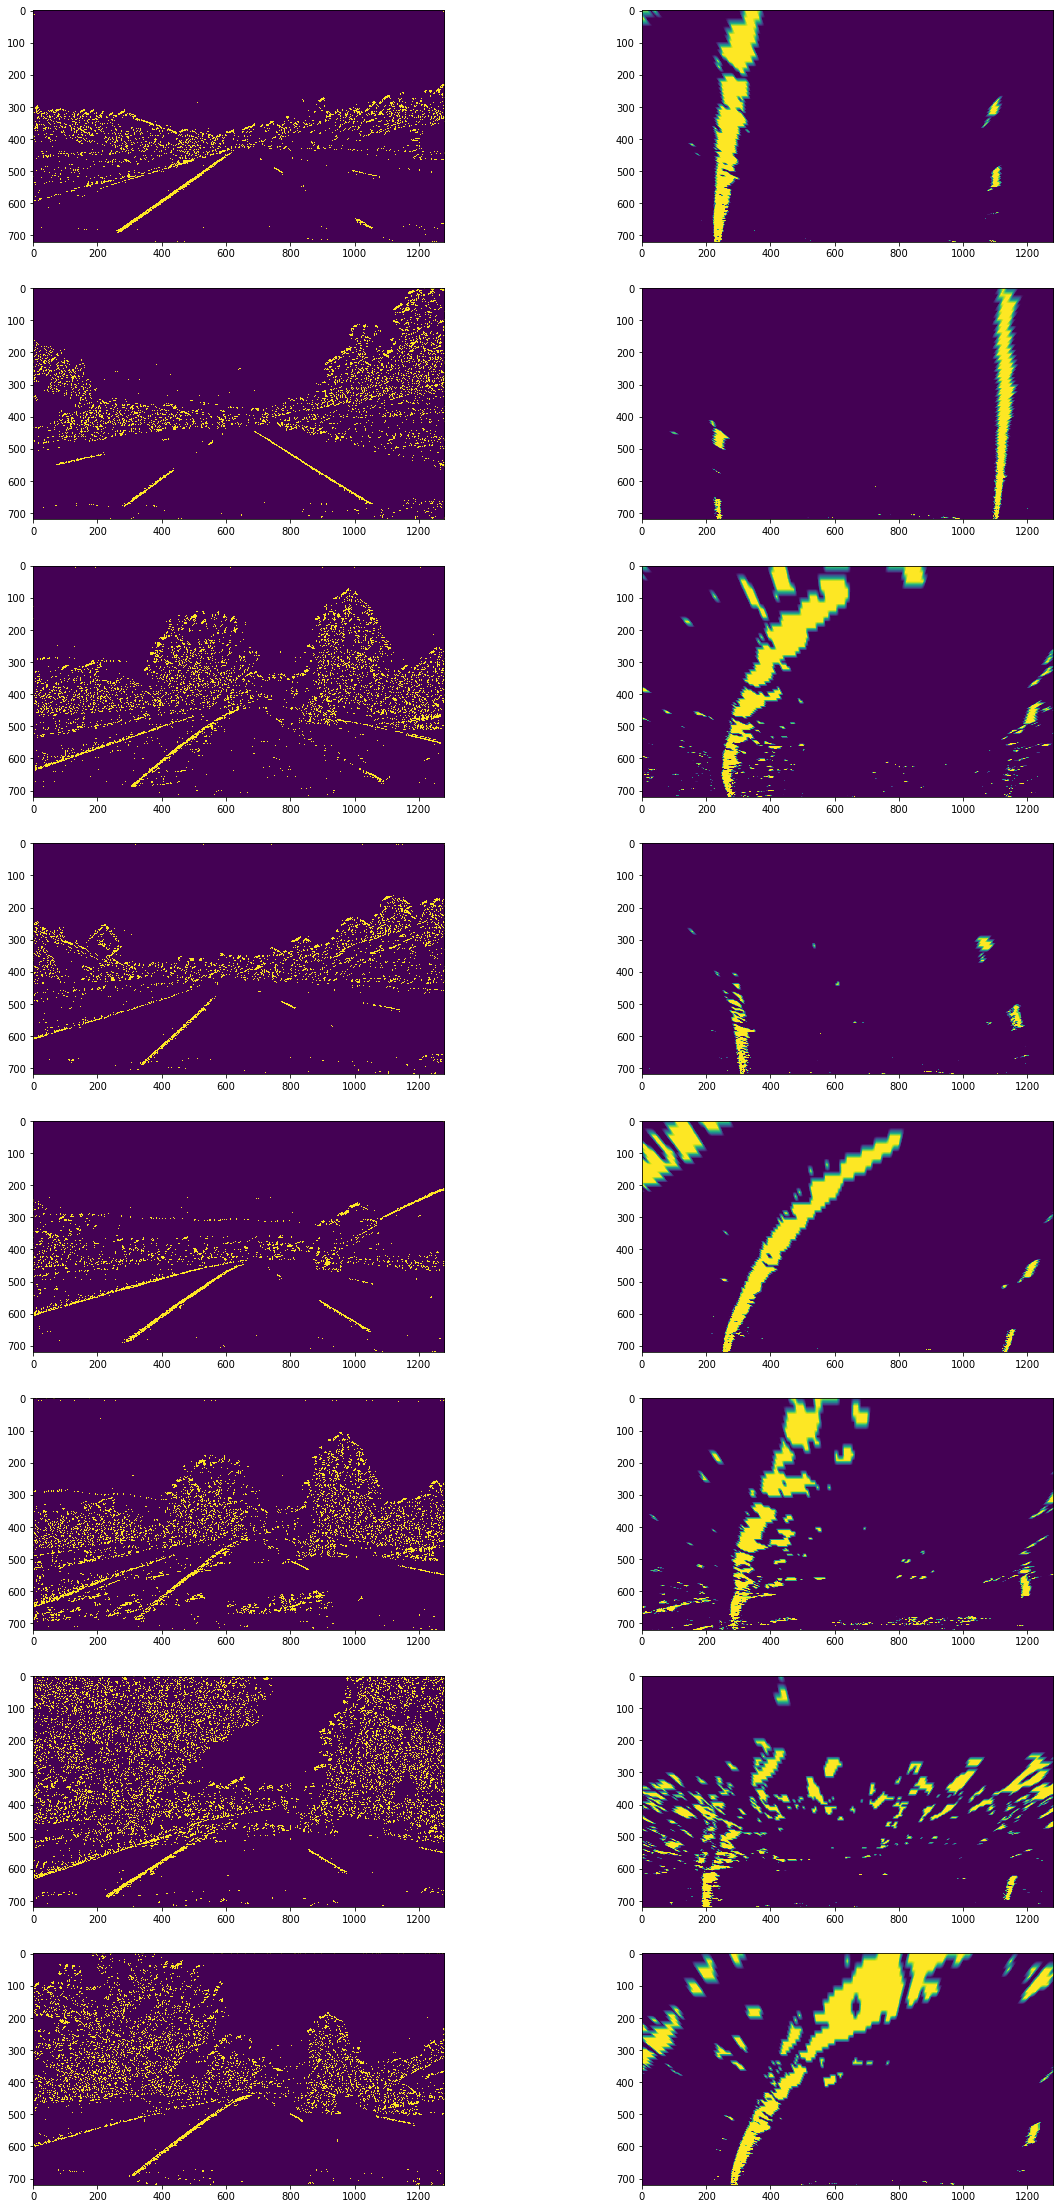

In [13]:
def birds_eye(image, M):
    img = np.copy(image)
    img = undistort(img)
    img = gradient_transform_wrapper(img)
    img = warp(img, M)
    return img


plt.figure(figsize=(20,40))
l = len(test_img)
for i, image in enumerate(test_img):
    img = undistort(image)
    plt.subplot(l, 2, i * 2 + 1)
    #plt.imshow(img)
    plt.imshow(gradient_transform_wrapper(image))
    plt.subplot(l, 2, i * 2 + 2)
    plt.imshow(birds_eye(img, M))
    


[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


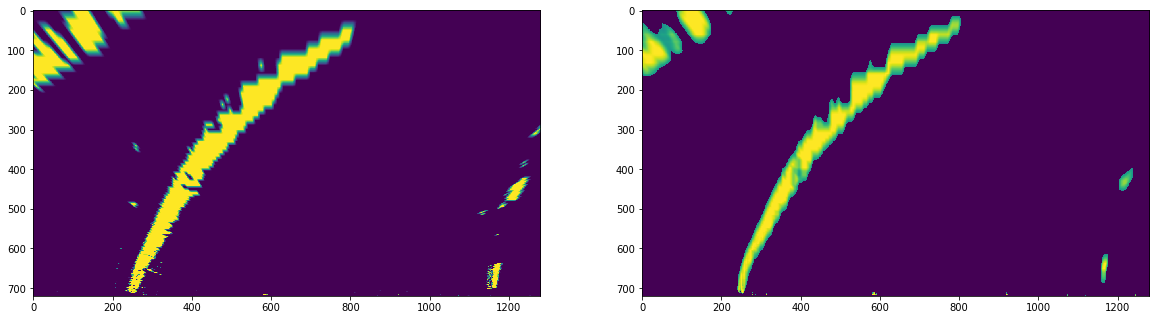

In [14]:
# histograms
from math import *
n=4
lane_data = warp(gradient_transform_wrapper(test_img[n]), M)

def hist_slide(data, wsize=50, thresh=0):
    out = np.zeros(data.shape)
    
    for y in range(data.shape[0]):
        start_y = y
        end_y = y + wsize
        if end_y > data.shape[0] : end_y = data.shape[0]
        
        window_hist = np.sum(data[start_y:end_y], axis=0)
        window_hist = window_hist / np.max(window_hist)

        window_hist[window_hist < 0.5] = 0
        out[y] = window_hist

    out[out < thresh] = 0
    
    return out
     
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(lane_data)
plt.subplot(1,2,2)
plt.imshow(hist_slide(lane_data))

print (lane_data)



In [15]:
from moviepy.editor import VideoFileClip
INPUT_VIDEO = './project_video.mp4'
clip = VideoFileClip(INPUT_VIDEO).subclip(39,42)
frames = [frame for frame in clip.iter_frames()]

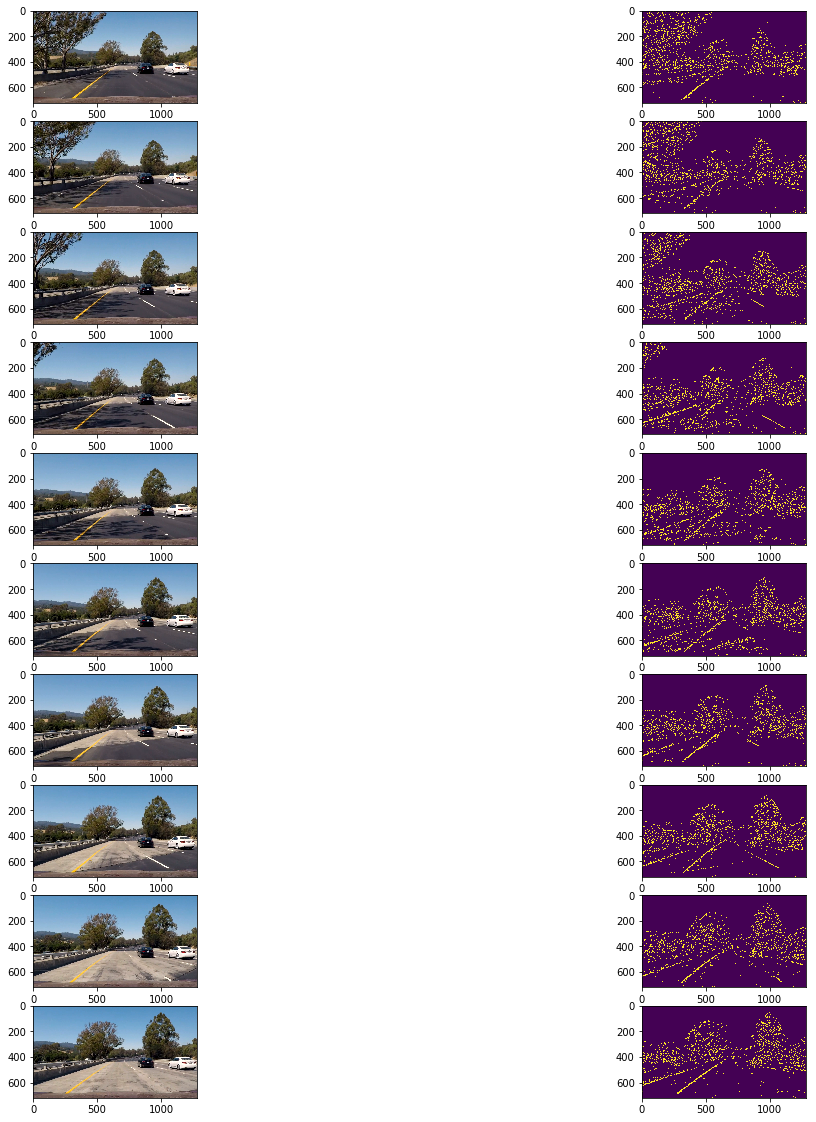

In [16]:
plt.figure(figsize=(20,20))
for i in range(10):
    
    plt.subplot(10,2,i*2+1)
    plt.imshow(frames[i*3])
    plt.subplot(10,2,i*2+2)
    #plt.imshow(birds_eye(frames[i*3], M))
    plt.imshow(gradient_transform_wrapper(frames[i*3]))
    

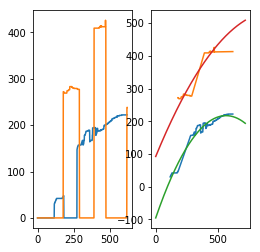

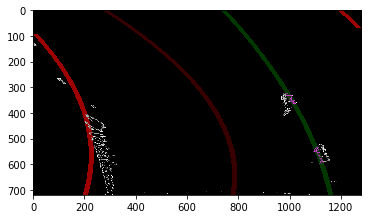

In [21]:
from moviepy.editor import VideoFileClip

INPUT_VIDEO = './project_video.mp4'

def fit_line_on_hist(p, degree=2, vis=False, plot=False):
    points = np.copy(p)
    y = np.argmax(points, axis=0)
    #y[y == 0] = np.mean([item for item in y if item != 0])

    last = np.mean(y)
    #finding first value
   
    x = np.arange(y.shape[0])
    #filtering zeros
    xx = []
    yy = []
    
    for i in range(len(x)):
        if y[i] != 0:
            xx.append(x[i])
            yy.append(y[i])

    #if (len(xx) == 0)
        
    xx = np.array(xx)
    yy = np.array(yy)
    
    #yy[yy < np.mean(yy) * 0.1] = np.mean(yy)
    #mean windowing
    window = 10
    for i in range(window, yy.shape[0]):
        if (yy[i] < np.mean(yy[i-window:i]) * 0.7):
            yy[i] = np.mean(yy[i-window:i])
        #if (yy[i] > np.mean(yy[i-window:i]) * 1.3):
        #    yy[i] = np.mean(yy[i-window:i])
            
            
    if plot:
        plt.subplot(1,3,1)
        plt.plot(x,y)
        plt.subplot(1,3,2)
        plt.plot(xx,yy)
            
    coeffs = np.polyfit(xx, yy, degree)
        
    return coeffs

def get_lane_curvatures(warped, length, top_crop=100,side_crop=70, plot = False):
        
    (coeff_l, coeff_r) = get_lane_coeffs(warped, length, top_crop, side_crop, plot)
    
    x = np.arange(length)
    
    curve_l = coeff_l[0] * x**2 + coeff_l[1] * x + coeff_l[2]
    curve_r = coeff_r[0] * x**2 + coeff_r[1] * x + coeff_r[2]
    
    if plot:
        plt.subplot(1,3,2)
        plt.plot(curve_l)
        plt.plot(curve_r)
    return (curve_l, curve_r)

def get_lane_coeffs(warped, length, top_crop=100,side_crop=70, plot = False):
        
    lane_data = np.copy(warped)
  
    mid = int(lane_data.shape[1] / 2)

    
    
    left = hist_slide(lane_data)[:,:mid].T
    right = hist_slide(lane_data)[:,mid:].T
    
    coeff_l = fit_line_on_hist(left[side_crop:,top_crop:], plot=plot)
    coeff_r = fit_line_on_hist(right[side_crop:,top_crop:], plot=plot)

    return (coeff_l, coeff_r)

def draw_curve_on_warped(warped, plot=False):
    
    lane_data = np.copy(warped)
    cropped = np.copy(lane_data)
    mid = int(lane_data.shape[1] / 2)

    lane_data = lane_data / np.max(lane_data) * 255
    rgb = np.zeros((warped.shape[0], warped.shape[1], 3))
    rgb[:,:,0] = lane_data
    rgb[:,:,1] = lane_data
    rgb[:,:,2] = lane_data
    curve_l, curve_r = get_lane_curvatures(cropped, lane_data.shape[0], plot=plot)
        
    curve_m = curve_l + curve_r / 2
    
    for i in range(len(curve_l)):
        rgb[i,int(curve_l[i]) : int(curve_l[i] + 20),0] = 100
        rgb[i,int(curve_r[i]) + mid : int(curve_r[i]) + mid + 20,1] = 200
        rgb[i,int(curve_m[i] + mid/2) : int(curve_m[i] + mid/2 + 20),0] = 200
    
    
    
    return np.float32(rgb)
    
        
    


n= 9
lane_curves = draw_curve_on_warped(birds_eye(frames[n], M), plot=True)

plt.figure(figsize=(20,20))
plt.subplot(1,3,3)
plt.imshow(lane_curves)



'\n    \nplt.figure(figsize=(20,20))\nplt.subplot(4,1,1)\nplt.imshow(highlight_lane(frames[11]))\nplt.subplot(4,1,2)\nplt.imshow(highlight_lane(frames[12]))\nplt.subplot(4,1,3)\nplt.imshow(highlight_lane(frames[13]))\nplt.subplot(4,1,4)\nplt.imshow(highlight_lane(frames[14]))\n'

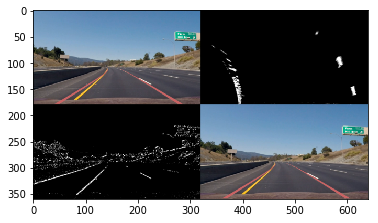

In [23]:


l_list = []
r_list = []
p_list = []


def highlight_lane(image):
    img = np.copy(image)
    # masking
    #if p_list :
    #    img[:,:,0][p_list[-1] != 1] = 0
    #    img[:,:,1][p_list[-1] != 1] = 10
    #    img[:,:,2][p_list[-1] != 1] = 50
    
    try:
        bird = birds_eye(img, M)
        coeff_l, coeff_r = get_lane_coeffs(bird, bird.shape[0])
    except TypeError:
        # without masking
        img = np.copy(image)
        bird = birds_eye(img, M)
        coeff_l, coeff_r = get_lane_coeffs(bird, bird.shape[0])

        
    l_list.append(coeff_l)
    r_list.append(coeff_r)
    """
    try:
        if abs(l_list[-1][0] - l_list[-2][0]) > 0.0025: l_list[-1][0] =  l_list[-2][0]
        if abs(r_list[-1][0] - r_list[-2][0]) > 0.0025: r_list[-1][0] =  r_list[-2][0]
    except IndexError:
        pass
    """ 
    
    coeff_l = np.mean(np.array(l_list[-10:]), axis=0)
    coeff_r = np.mean(np.array(r_list[-10:]), axis=0) 
  
    

    x = np.arange(bird.shape[0])  
    curve_l = coeff_l[0] * x**2 + coeff_l[1] * x + coeff_l[2]
    curve_r = coeff_r[0] * x**2 + coeff_r[1] * x + coeff_r[2]
    
    mid = int(bird.shape[1] / 2)
    lanes = np.zeros(bird.shape)
    for i in range(bird.shape[0]):
        lx = int(curve_l[i])
        rx = int(curve_r[i] + mid)
        lanes[i,lx-20:lx+20] = 1
        lanes[i, rx-20:rx +20] = 1
    
    perspective = warp(lanes, M_INV)
    p_list.append(perspective)
    
    image[:,:,0][perspective == 1] = 200
    image[:,:,1][perspective == 1] = 100
    image[:,:,2][perspective == 1] = 100
    return image
  
    
def gen_frame(image, bird_crop=0):
    img = np.copy(image)
    grad = gradient_transform_wrapper(image)
    bird = birds_eye(image, M)
    
    grad_rgb = np.zeros(img.shape)
    grad_rgb[:,:,0] = grad
    grad_rgb[:,:,1] = grad
    grad_rgb[:,:,2] = grad
    grad_rgb[grad_rgb == 1] = 255
    
    lane_curves = highlight_lane(img)

    bird = bird / np.max(bird) * 255
    bird_rgb = np.zeros(img.shape)
    bird_rgb[:,:,0] = bird
    bird_rgb[:,:,1] = bird
    bird_rgb[:,:,2] = bird
    
   

    undistorted = undistort(img)
    
    up = np.concatenate((img, bird_rgb), axis=1)
    down = np.concatenate((grad_rgb, lane_curves), axis=1)
    
    out = np.concatenate((up, down), axis=0)
    
    return misc.imresize(np.uint8(out), (360, 640))
    

clip = VideoFileClip(INPUT_VIDEO).subclip(2,10)
frames = [frame for frame in clip.iter_frames()]

plt.imshow(gen_frame(frames[0]))


"""
    
plt.figure(figsize=(20,20))
plt.subplot(4,1,1)
plt.imshow(highlight_lane(frames[11]))
plt.subplot(4,1,2)
plt.imshow(highlight_lane(frames[12]))
plt.subplot(4,1,3)
plt.imshow(highlight_lane(frames[13]))
plt.subplot(4,1,4)
plt.imshow(highlight_lane(frames[14]))
"""


#plt.imshow(gen_frame(frames[140]))

(1, 3)


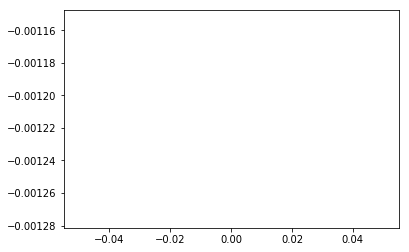

In [19]:

l = np.array(l_list)
print(l.shape)
plt.plot(l[:,0])
#plt.plot(l[:,1])
#plt.plot(l[:,2])

for i in range(len(l)):
    if abs(l[i,0] - l[i-1,0]) > 0.0025 : l[i,0] = l[i-1,0]

#plt.plot(l[:,0])

In [24]:
from moviepy.editor import VideoFileClip

INPUT_VIDEO = './project_video.mp4'
OUTPUT_VIDEO = './output_video2.mp4'

def write_video(input_f, output_f, f):
    clip = VideoFileClip(input_f)#.subclip(1,10)
    transformed = clip.fl_image(f)
    transformed.write_videofile(output_f, audio=False)
 


write_video(INPUT_VIDEO, OUTPUT_VIDEO, gen_frame)

[MoviePy] >>>> Building video ./output_video2.mp4
[MoviePy] Writing video ./output_video2.mp4



100%|█████████▉| 1260/1261 [20:17<00:00,  1.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_video2.mp4 

